In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


##### 1. Для планирования эксперимента изучите данные и метрики:

In [6]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [7]:
df.head()

Timestamp('2019-12-09 00:00:00')

In [21]:
df['event_date'].max(), df['event_date'].min()# у нас данные за 2 месяца

(Timestamp('2019-12-09 00:00:00'), Timestamp('2019-06-18 00:00:00'))

In [8]:
# рассчет средней выручки
df.revenue_amount.mean()

400.9046571917269

In [9]:
# рассчет стандартного отклонения для выручки
df.revenue_amount.std()

960.2217414899865

In [10]:
df.groupby(['user_segment'])['revenue_amount'].mean()
# сегменты заметно отличаются по средней выручке

user_segment
853431062533847667     1094.330305
2376074197230840906     401.615956
4626944681007198896     207.760172
Name: revenue_amount, dtype: float64

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 207.76017233,  216.62587365,  225.49157498,  234.35727631,
         243.22297764,  252.08867897,  260.9543803 ,  269.82008163,
         278.68578296,  287.55148429,  296.41718562,  305.28288694,
         314.14858827,  323.0142896 ,  331.87999093,  340.74569226,
         349.61139359,  358.47709492,  367.34279625,  376.20849758,
         385.07419891,  393.93990024,  402.80560156,  411.67130289,
         420.53700422,  429.40270555,  438.26840688,  447.13410821,
         455.99980954,  464.86551087,  473.7312122 ,  482.59691353,
      

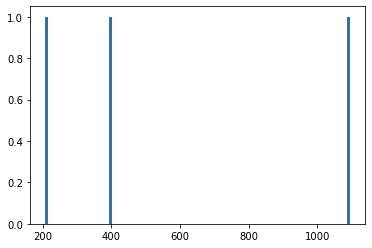

In [20]:
plt.hist(df.groupby(['user_segment'])['revenue_amount'].mean(), bins = 100)

In [11]:
df.groupby(['user_segment'])['revenue_amount'].std()
# также сегменты сильно различаются по стандартному отклонению

user_segment
853431062533847667     2392.330098
2376074197230840906     571.446013
4626944681007198896     285.545686
Name: revenue_amount, dtype: float64

In [12]:
df.groupby(['region'])['revenue_amount'].mean().sort_values()

region
1706841507230707778    182.157253
6371282152022805074    187.891898
9173615405044165275    189.498536
8666105090637809898    192.322772
8443241763018219192    192.534498
                          ...    
8867014108346120905    445.188098
1611023233668261710    529.945146
5780543780372929118    536.875280
4848067518890897757    644.019141
1481836092404435976    709.130762
Name: revenue_amount, Length: 84, dtype: float64

In [18]:
df.groupby(['region'])['revenue_amount'].std().sort_values()

region
8666105090637809898     222.724661
8443241763018219192     227.287387
9173615405044165275     230.607352
928013360687874809      239.776537
6371282152022805074     256.364711
                          ...     
1611023233668261710    1069.926166
2751451541457411742    1241.044595
5780543780372929118    1324.789564
4848067518890897757    1407.455008
1481836092404435976    1819.635279
Name: revenue_amount, Length: 84, dtype: float64

(array([1., 4., 1., 0., 2., 3., 1., 2., 3., 3., 3., 5., 0., 3., 2., 4., 0.,
        4., 1., 4., 2., 2., 3., 1., 1., 1., 4., 1., 1., 3., 2., 0., 1., 1.,
        1., 2., 0., 0., 0., 3., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([182.15725289, 187.42698798, 192.69672307, 197.96645816,
        203.23619326, 208.50592835, 213.77566344, 219.04539853,
        224.31513362, 229.58486872, 234.85460381, 240.1243389 ,
        245.39407399, 250.66380908, 255.93354418, 261.20327927,
        266.47301436, 271.74274945, 277.01248454, 282.28221964,
        287.55195473, 292.82168982, 298.09142491, 303.36116   ,
        308.6308951 , 313.90063019, 319.17036528, 324.44010037,
        329.70983546, 334.97957056, 340.24930565, 345.51904074,
        350.78877583, 356.05851092, 36

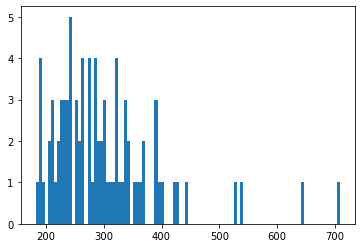

In [19]:
# в основном средняя прибыль по региону от 200 до 400, при этом есть несколько регионов, где среднее около 500-700
plt.hist(df.groupby(['region'])['revenue_amount'].mean(), bins = 100)

In [14]:
df.groupby(['category'])['revenue_amount'].mean().sort_values()

category
4394253463123676325     136.595029
3619272498251215842     142.088606
5387097547938806535     149.053532
7247164925237372155     155.169288
6847326422676498281     167.567493
2965866302161963961     196.501761
3429514168013826643     200.418644
4658595883120885993     215.218327
6864443610550051939     233.014721
1472231361867825698     258.353200
282115902545472456      260.778575
320230973495659885      286.013254
1560592244484430230     313.285665
5736208844128861898     321.823084
174490086998335078      325.149759
57514010642945023       347.826167
7204754148424990691     352.174948
4409084324312788296     379.733922
3358911609809004109     403.792946
6549025562984299367     410.800302
5983323600580891431     433.565037
91460430793700892       441.861699
5284347926600386297     455.255782
3187769798308634693     467.654020
1793067034829450750     497.431001
6742557862815872936     503.182713
264558924403680107      509.373364
4546178272531746227     510.431362
58581895968

In [15]:
df.groupby(['category'])['revenue_amount'].std().sort_values()

category
3619272498251215842     172.984799
5387097547938806535     196.446707
4658595883120885993     279.414560
3429514168013826643     281.092885
7247164925237372155     285.421869
4394253463123676325     300.843418
6847326422676498281     311.475321
2965866302161963961     350.682200
282115902545472456      354.734991
320230973495659885      414.997017
1560592244484430230     464.354426
6864443610550051939     471.848055
7204754148424990691     511.821260
5284347926600386297     534.420842
5983323600580891431     535.078480
1472231361867825698     594.984151
57514010642945023       605.864274
5736208844128861898     625.686617
91460430793700892       651.938097
5858189596811644833     699.154653
4546178272531746227     717.762308
264558924403680107      747.222091
174490086998335078      764.813512
6742557862815872936     778.842570
3187769798308634693     790.312625
3358911609809004109     791.225418
4409084324312788296     889.850240
1793067034829450750    1073.795206
79482703251

(array([3., 2., 0., 2., 1., 1., 2., 0., 1., 1., 2., 2., 0., 1., 1., 1., 2.,
        1., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 136.59502924,  154.78887326,  172.98271728,  191.1765613 ,
         209.37040532,  227.56424934,  245.75809336,  263.95193738,
         282.1457814 ,  300.33962542,  318.53346944,  336.72731346,
         354.92115748,  373.1150015 ,  391.30884552,  409.50268954,
         427.69653356,  445.89037758,  464.0842216 ,  482.27806562,
         500.47190964,  518.66575366,  536.85959768,  555.0534417 ,
         573.24728572,  591.44112974,  609.63497376,  627.82881778,
         646.0226618 ,  664.21650582,  682.41034984,  700.60419386,
      

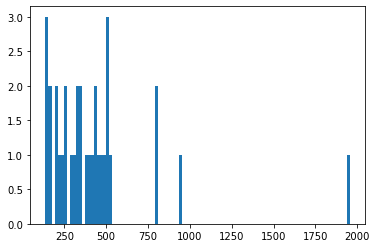

In [17]:
# среднее по категориям лежит между 200 и 500, при этом есть один сегмент, с очень высокой выручкой -- около 1950
plt.hist(df.groupby(['category'])['revenue_amount'].mean(), bins = 100)

##### 2. Предскажите минимально детектируемый эффект (MDE):

Для рассчетов 9-ти комбинаций (Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней) с помощью кода ниже , заеняя параметры delta, share и result effect) получены MDE:

Для тестовой группы 10% и длительности теста 30 дней: 9%  
Для тестовой группы 10% и длительности теста 60 дней: 8.5%  
Для тестовой группы 10% и длительности теста 90 дней: 9.5%  
 
Для тестовой группы 25% и длительности теста 30 дней: 6.1%  
Для тестовой группы 25% и длительности теста 60 дней: 5.5%  
Для тестовой группы 25% и длительности теста 90 дней: 5.4%  

Для тестовой группы 50% и длительности теста 30 дней: 4.7%  
Для тестовой группы 50% и длительности теста 60 дней: 4.5%  
Для тестовой группы 50% и длительности теста 90 дней: 4.5%  

In [189]:
def choose_date(df, start_date, delta, share): 
    tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x


In [258]:
# Эксперимент будем проводить на всей выборке.
import datetime

x1 = choose_date(df, datetime.datetime(2019, 7, 19, 0, 0), 30 ,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.046 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки


1.029721162117055


##### 3. CUPED

1. Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала).

Для рассчета метрики возьмем данные за первые 30 дней из датасета, добавим новый столбец pre_revenue к нашему df

In [259]:
df['event_date'].min()

Timestamp('2019-06-18 00:00:00')

In [260]:
pre_df = df[df['event_date'] <= '2019-07-18']
pre_df_avg = pre_df.groupby(['user_id'])['revenue_amount'].mean()

In [353]:
new_df = df[(df['event_date'] > '2019-07-18') & (df['event_date'] <= '2019-08-18')]
new_df_avg = new_df.groupby(['user_id'])['revenue_amount'].mean()

In [354]:
n_df = pd.merge(new_df_avg,pre_df_avg,on='user_id', how='left') 

In [355]:
n_df['revenue_amount_y'] = n_df['revenue_amount_y'].fillna(0)

In [356]:
# Получили df, в котором хранится информация для каждого пользователя по его среднему чеку за заказаз 
# в период с 18 июня 2019 года по 18 июля 2019 года
n_df.head()

,revenue_amount_x,revenue_amount_y
user_id,,
702221222224,356.000000,0.0
1912219714366,100.333333,70.0
23708868092799,48.000000,55.0
39239811475386,195.000000,293.0
45305541518475,125.000000,0.0


In [357]:
# начнем рассчет  CUPID метрики
# Считаем среднее предданных:
n_df['pre_revenue_tg_average']=n_df.revenue_amount_y.mean() 

In [358]:
teta = np.cov(n_df.revenue_amount_x,n_df.revenue_amount_y, ddof=1)[1,0]/np.var(n_df.revenue_amount_y, ddof=1)
teta

0.7502038946462856

In [359]:
corr = np.corrcoef(n_df.revenue_amount_x,n_df.revenue_amount_y)[1,0] 

In [360]:
# Считаем CUPID метрику
n_df['cuped_revenue'] = n_df.revenue_amount_x - teta * (n_df.revenue_amount_y - n_df.pre_revenue_tg_average)

In [361]:
n_df.head()

,revenue_amount_x,revenue_amount_y,pre_revenue_tg_average,cuped_revenue
user_id,,,,
702221222224,356.000000,0.0,173.118706,485.874327
1912219714366,100.333333,70.0,173.118706,177.693388
23708868092799,48.000000,55.0,173.118706,136.613113
39239811475386,195.000000,293.0,173.118706,105.064586
45305541518475,125.000000,0.0,173.118706,254.874327


In [362]:
# MDE
def choose_date(df, start_date, delta, share): 
    #tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=n_df.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x

In [365]:
# Эксперимент будем проводить на всей выборке.
# Удалось уменьшить MDE с 4.5% до 0.9%!
import datetime

x1 = choose_date(n_df, datetime.datetime(2019, 7, 19, 0, 0), 30 ,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.cuped_revenue.mean()
std = x1.cuped_revenue.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.009 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки


0.994803756567487


2. Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды.

Рассмотрим MDE для CUPED метрики, если будем брать период за сентябрь и за новбрь. Основной дата теста будет в первом случае от сентбяря до конца года, во втором - от ноября до уонца года

Сентябрь

In [368]:
# Проделаем те же действия, что мы делали для первого месяца
pre_sep_df = df[(df['event_date'] >= '2019-09-01') & (df['event_date'] <= '2019-09-30')]
pre_sep_df_avg = pre_sep_df.groupby(['user_id'])['revenue_amount'].mean()

In [369]:
new_sep_df = df[(df['event_date'] > '2019-09-30') & (df['event_date'] <= '2019-10-31')]
new_sep_df_avg = new_sep_df.groupby(['user_id'])['revenue_amount'].mean()

In [370]:
n_sep_df = pd.merge(new_sep_df_avg,pre_sep_df_avg,on='user_id', how='left')
n_sep_df['pre_revenue_tg_average']=n_sep_df.revenue_amount_y.mean() 

In [371]:
n_sep_df['revenue_amount_y'] = n_sep_df['revenue_amount_y'].fillna(0)

In [372]:
teta = np.cov(n_sep_df.revenue_amount_x,n_sep_df.revenue_amount_y, ddof=1)[1,0]/np.var(n_sep_df.revenue_amount_y, ddof=1)
corr = np.corrcoef(n_sep_df.revenue_amount_x,n_sep_df.revenue_amount_y)[1,0] 
n_sep_df['cuped_revenue'] = n_sep_df.revenue_amount_x - teta * (n_sep_df.revenue_amount_y - n_sep_df.pre_revenue_tg_average)

In [373]:
# MDE при данных для предпирода за сентябрь
def choose_date_sep(df, start_date, delta, share): 
    #tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=n_sep_df.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x

In [385]:

import datetime

x1 = choose_date_sep(n_sep_df, datetime.datetime(2019, 10, 1, 0, 0), 30 ,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.cuped_revenue.mean()
std = x1.cuped_revenue.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.0057 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

# MDE умениьшился с 0.9% до 0.57%

1.0137549029806718


Ноябрь

In [386]:
# Проделаем те же действия, что мы делали для первого месяца
pre_nov_df = df[(df['event_date'] >= '2019-10-01') & (df['event_date'] <= '2019-10-31')]
pre_nov_df_avg = pre_nov_df.groupby(['user_id'])['revenue_amount'].mean()

In [387]:
new_nov_df = df[(df['event_date'] > '2019-11-30') & (df['event_date'] <= '2019-12-31')]
new_nov_df_avg = new_nov_df.groupby(['user_id'])['revenue_amount'].mean()

In [389]:
n_nov_df = pd.merge(new_nov_df_avg,pre_nov_df_avg,on='user_id', how='left')
n_nov_df['pre_revenue_tg_average']=n_nov_df.revenue_amount_y.mean() 
n_nov_df['revenue_amount_y'] = n_nov_df['revenue_amount_y'].fillna(0)

In [390]:
teta = np.cov(n_nov_df.revenue_amount_x,n_nov_df.revenue_amount_y, ddof=1)[1,0]/np.var(n_nov_df.revenue_amount_y, ddof=1)
corr = np.corrcoef(n_nov_df.revenue_amount_x,n_nov_df.revenue_amount_y)[1,0] 
n_nov_df['cuped_revenue'] = n_nov_df.revenue_amount_x - teta * (n_nov_df.revenue_amount_y - n_nov_df.pre_revenue_tg_average)


In [391]:
# MDE при данных для предпирода за сентябрь
def choose_date_nov(df, start_date, delta, share): 
    #tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=n_nov_df.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x

In [409]:
import datetime

x1 = choose_date_nov(n_nov_df, datetime.datetime(2019, 10, 1, 0, 0), 30 ,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.cuped_revenue.mean()
std = x1.cuped_revenue.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.011 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

#Используя данные за ноябрь, получается засечь изменение в 1.1%

0.9866054287467663


3. Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь.  

In [1]:
# Рассмотрим MDE за разные периоды
def choose_date(df, start_date, delta, share): 
    #tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=n_df.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x

###### 4. Стратификация 

Регион

In [333]:
strata_p = df.groupby(['region']).count()/df.count()[0]
data_test=df.join(strata_p, on='region', rsuffix='_probality')

In [336]:
(data_test.groupby(['region']).mean().revenue_amount*data_test.groupby(['region']).mean().revenue_amount_probality).sum()

400.9046571927835

In [339]:
((data_test.groupby(['region']).var().revenue_amount*data_test.groupby(['region']).mean().revenue_amount_probality).sum()
 /df.count()[0])**0.5

0.32297647035389626

category

In [342]:
strata_p = df.groupby(['category']).count()/df.count()[0]
data_test=df.join(strata_p, on='category', rsuffix='_probality')

In [ ]:
(data_test.groupby(['category']).mean().revenue_amount*data_test.groupby(['category']).mean().revenue_amount_probality).sum()


In [344]:
((data_test.groupby(['category']).var().revenue_amount*data_test.groupby(['category']).mean().revenue_amount_probality).sum()
 /df.count()[0])**0.5

0.32066184266339565

User ID

In [345]:
strata_p = df.groupby(['user_segment']).count()/df.count()[0]
data_test=df.join(strata_p, on='user_segment', rsuffix='_probality')

In [346]:
(data_test.groupby(['user_segment']).mean().revenue_amount*data_test.groupby(['user_segment']).mean().revenue_amount_probality).sum()


400.9046571988347

In [347]:
((data_test.groupby(['user_segment']).var().revenue_amount*data_test.groupby(['user_segment']).mean().revenue_amount_probality).sum()
 /df.count()[0])**0.5

0.3140204036179203